---
## Imports
---
Below, we will import our dataset and all the libraries that will be used throughout this notebook.

In [0]:
# List files in /FileStore/tables to confirm the csv is there
display(dbutils.fs.ls("/FileStore/tables")[:10])

path,name,size,modificationTime
dbfs:/FileStore/tables/2025_03_11___DBFS_Example_Classifier.ipynb,2025_03_11___DBFS_Example_Classifier.ipynb,68203,1742288094000
dbfs:/FileStore/tables/Clean_IMDBnew.csv,Clean_IMDBnew.csv,11897936,1748379618000
dbfs:/FileStore/tables/Clean_IMDBnew.parquet/,Clean_IMDBnew.parquet/,0,0
dbfs:/FileStore/tables/IMDB_CLEAN.csv,IMDB_CLEAN.csv,16096967,1748425316000
dbfs:/FileStore/tables/IMDB_CLEAN.parquet/,IMDB_CLEAN.parquet/,0,0
dbfs:/FileStore/tables/IMDB_Cleaned/,IMDB_Cleaned/,0,0
dbfs:/FileStore/tables/IMDB_cleannew.csv,IMDB_cleannew.csv,16096967,1748387484000
dbfs:/FileStore/tables/Imdb_Movie_Dataset-1.csv,Imdb_Movie_Dataset-1.csv,392283051,1746882391000
dbfs:/FileStore/tables/Imdb_Movie_Dataset-4.csv/,Imdb_Movie_Dataset-4.csv/,0,0
dbfs:/FileStore/tables/Imdb_Movie_Dataset.csv/,Imdb_Movie_Dataset.csv/,0,0


In [0]:
# File location and type
file_location = "/FileStore/tables/Imdb_Movie_Dataset-1.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
# quote <-- Important to handle commas correctly
df = (
    spark.read.format(file_type)
    .option("inferSchema", infer_schema)
    .option("header", first_row_is_header)
    .option("sep", delimiter)
    .option("quote", '"')
    .option("escape", '"')
    .load(file_location)
)

display(df.limit(5))

id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
27205,Inception,8.364,34495,Released,7/15/2010,825532764,148,false,160000000,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pictures","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious"
157336,Interstellar,8.417,32571,Released,11/5/2014,701729206,169,false,165000000,tt0816692,en,Interstellar,The adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.,140.241,Mankind was born on Earth. It was never meant to die here.,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Productions","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time, artificial intelligence (a.i.), nasa, time warp, dystopia, expedition, space travel, wormhole, famine, black hole, quantum mechanics, family relationships, space, robot, astronaut, scientist, single father, farmer, space station, curious, space adventure, time paradox, thoughtful, time-manipulation, father daughter relationship, 2060s, cornfield, time manipulation, complicated"
155,The Dark Knight,8.512,30619,Released,7/16/2008,1004558444,152,false,185000000,tt0468569,en,The Dark Knight,"Batman raises the stakes in his war on crime. With the help of Lt. Jim Gordon and District Attorney Harvey Dent, Batman sets out to dismantle the remaining criminal organizations that plague the streets. The partnership proves to be effective, but they soon find themselves prey to a reign of chaos unleashed by a rising criminal mastermind known to the terrified citizens of Gotham as the Joker.",130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel Griffiths, Warner Bros. Pictures","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime fighter, superhero, anti hero, scarecrow, based on comic, vigilante, organized crime, tragic hero, anti villain, criminal mastermind, district attorney, super power, super villain, neo-noir"
19995,Avatar,7.573,29815,Released,12/15/2009,2923706026,162,false,237000000,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, 20th Century Fox, Ingenious Media","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, space war, space colony, tribe, romance, alien, futuristic, space, alien planet, marine, soldier, battle, love affair, nature, anti war, power relations, joyful"
24428,The Avengers,7.71,29166,Released,4/25/2012,1518815515,143,false,220000000,tt0848228,en,The Avengers,"When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disast

In [0]:
# Import the libraries
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, when, isnan, row_number, to_date, split, regexp_replace, expr, corr
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType, BooleanType, FloatType, LongType, DoubleType

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.feature import VectorAssembler, StandardScaler, ChiSqSelector, QuantileDiscretizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")  # to parse the release date without problems

---
## Define the Data Cleaning Function
---
In the previous notebooks we performed a full analysis of our dataset. Now, we will define a function (and a helper function) that applies all the cleaning steps we decided on earlier.

In [0]:
def drop_duplicates_keep_least_null(df, id_col):
    """
    Deduplicate on `id_col`, keeping the row with the fewest null values.
    Rows with null `id_col` are left unchanged.
    """
    print(f"Starting deduplication on column: {id_col}")

    non_null_df = df.filter(col(id_col).isNotNull())
    null_df     = df.filter(col(id_col).isNull())
    print(f"Rows with non-null '{id_col}': {non_null_df.count()}")
    print(f"Rows with null '{id_col}': {null_df.count()}")

    null_count_expr = sum(
        when(col(c).isNull(), 1).otherwise(0) for c in non_null_df.columns
    ).alias("_null_cnt")

    nn_with_counts = non_null_df.withColumn("_null_cnt", null_count_expr)
    print("Added null count column for ranking")

    w = Window.partitionBy(id_col).orderBy(col("_null_cnt").asc())
    ranked = nn_with_counts.withColumn("_rn", row_number().over(w))
    print("Ranked rows within each group")

    deduped = (
        ranked
        .filter(col("_rn") == 1)
        .drop("_null_cnt", "_rn")
    )
    print("Filtered to keep only top-ranked rows with fewest nulls")

    result_df = deduped.unionByName(null_df)
    print(f"Final row count after deduplication on '{id_col}': {result_df.count()}")
    return result_df

def _build_top_indicator(df, col_name, top_n, suffix):
    """
    For a comma-separated string column (e.g., 'Adventure, Comedy, Science Fiction'),
    create binary columns for the top-N most profitable individual items.
    """
    print(f"Creating top-{top_n} binary indicator columns for: {col_name}")
    arr_col = F.split(F.col(col_name), ",\\s*")

    exploded = (
        df.select(arr_col.alias("arr"), "revenue")
          .withColumn("item", F.explode("arr"))
          .withColumn("item", F.trim(F.col("item")))
          .groupBy("item")
          .agg(F.sum("revenue").alias("tot_rev"))
          .orderBy(F.col("tot_rev").desc())
          .limit(top_n)
    )

    top_items = [row["item"] for row in exploded.collect()]
    print(f"Top {top_n} items for '{col_name}': {top_items}")

    for item in top_items:
        clean_name = item.strip().lower().replace(" ", "_").replace("-", "_").replace("(", "").replace(".", "")
        df = df.withColumn(
            f"{suffix}_{clean_name}",
            F.when(F.array_contains(arr_col, item), 1).otherwise(0)
        )
        print(f"Created binary column: {suffix}_{clean_name}")

    return df

# Our main data cleaner
def initial_preprocess(df):
    """
    1. Drop rows with revenue == 0 (it's our first step to make the dataset lighter and thus the following operations faster)
    2. Replace literal 'None' / 'none' in imdb_id with null
    3. Deduplicate on id, then on imdb_id using fewest-null rule
    4. Drop heavy text cols and imdb_id after
    5. Change the data types to correct ones
    6. Fix incorrect values for vote_average (should only be in the range 1-10)
    7. Set the vote vote_average to zero, when vote_count == 0
    8. Cast the release_date to data type 
    """
    print("Step 1: Dropping rows with revenue = 0")
    df = df.filter(F.col("revenue") != 0)

    print("Step 2: Replacing 'None' strings in imdb_id with null")
    none_count = df.filter(F.lower(col("imdb_id")) == "none").count()
    df = df.withColumn(
        "imdb_id",
        when(F.lower(col("imdb_id")) == "none", None).otherwise(col("imdb_id"))
    )
    print(f"Number of 'None' values replaced with null in 'imdb_id': {none_count}")

    print("Step 3a: Deduplicating by id")
    df = drop_duplicates_keep_least_null(df, id_col="id")

    print("Step 3b: Deduplicating by imdb_id")
    df = drop_duplicates_keep_least_null(df, id_col="imdb_id")

    print("Step 4: Dropping unused text columns")
    df = df.drop("imdb_id", "title", "original_title", "overview", "spoken_languages")
    
    print("Step 5: Casting to correct data types")
    df = (
        df
        .withColumn("vote_average",  F.col("vote_average").cast(DoubleType()))
        .withColumn("popularity",    F.col("popularity").cast(DoubleType()))
        .withColumn("vote_count",    F.col("vote_count").cast(IntegerType()))
        .withColumn("runtime",       F.col("runtime").cast(IntegerType()))
        .withColumn("adult",         F.col("adult").cast(IntegerType()))
        .withColumn("revenue",       F.col("revenue").cast(LongType()))
        .withColumn("budget",        F.col("budget").cast(LongType()))
    )

    print("Step 6: Fixing out-of-range vote_average values")
    df = df.withColumn(
        "vote_average",
        F.when((F.col("vote_average") < 1) | (F.col("vote_average") > 10), 0.0)
         .otherwise(F.col("vote_average"))
    )

    print("Step 7: Setting vote_average to 0 where vote_count == 0")
    df = df.withColumn(
        "vote_average",
        F.when((F.col("vote_count") == 0) & (F.col("vote_average") != 0), 0.0)
         .otherwise(F.col("vote_average"))
    )
    print("Step 8: Parsing release_date using multiple formats")
    date_eu  = F.to_date(F.col("release_date"), "dd/MM/yyyy")
    date_us  = F.to_date(F.col("release_date"), "MM/dd/yyyy")
    date_iso = F.to_date(F.col("release_date"), "yyyy-MM-dd")
    df = df.withColumn("parsed_date", F.coalesce(date_eu, date_us, date_iso))

    print("Step 9: Creating release_day, release_month, release_year")
    df = (
        df
        .withColumn("release_day",   F.dayofmonth("parsed_date").cast(IntegerType()))
        .withColumn("release_month", F.month("parsed_date").cast(IntegerType()))
        .withColumn("release_year",  F.year("parsed_date").cast(IntegerType()))
    )
    print("Filling missing values in release_day, release_month, release_year with 0")
    df = (
        df
        .withColumn("release_day",   F.when(F.col("release_day").isNull(),   0).otherwise(F.col("release_day")))
        .withColumn("release_month", F.when(F.col("release_month").isNull(), 0).otherwise(F.col("release_month")))
        .withColumn("release_year",  F.when(F.col("release_year").isNull(),  0).otherwise(F.col("release_year")))
    )


    print("Initial preprocessing complete.")
    return df

---
## Clean the Data
---
Let's apply the cleaning function to the original imdb dataframe.

In [0]:
# Apply initial preprocessing
df_clean = initial_preprocess(df)

Step 1: Dropping rows with revenue = 0
Step 2: Replacing 'None' strings in imdb_id with null
Number of 'None' values replaced with null in 'imdb_id': 4
Step 3a: Deduplicating by id
Starting deduplication on column: id
Rows with non-null 'id': 20676
Rows with null 'id': 0
Added null count column for ranking
Ranked rows within each group
Filtered to keep only top-ranked rows with fewest nulls
Final row count after deduplication on 'id': 20674
Step 3b: Deduplicating by imdb_id
Starting deduplication on column: imdb_id
Rows with non-null 'imdb_id': 16927
Rows with null 'imdb_id': 3747
Added null count column for ranking
Ranked rows within each group
Filtered to keep only top-ranked rows with fewest nulls
Final row count after deduplication on 'imdb_id': 20664
Step 4: Dropping unused text columns
Step 5: Casting to correct data types
Step 6: Fixing out-of-range vote_average values
Step 7: Setting vote_average to 0 where vote_count == 0
Step 8: Parsing release_date using multiple formats
Ste

In [0]:
# Print dataframe shape after cleaning
row_count = df_clean.count()
col_count = len(df_clean.columns)

print(f"Shape: ({row_count}, {col_count})")

Shape: (20664, 20)


---
## Train-test split
---
Here, we split the dataset into train and test before moving on to the feature engineering and subsequent steps. We do this to avoid data leakage as we will use information related to target to create some new columns.

In [0]:
# Split the data
train_df, test_df = df_clean.randomSplit([0.8, 0.2], seed=12)

---
## Define the data engineering function
---

In [0]:
def feature_engineer(df, train_df_for_reference):
    """
    Performs feature engineering on the df using the training data as reference to avoid data leakage

    Steps:
    1. Fill missing or zero 'runtime' values using the median from the training set
    2. Create binary indicator 'released_bool' from the 'status' column
    3. Create binary indicator 'en_bool' for movies originally in English
    4. Create binary indicator 'tagline_bool' based on the presence of a tagline
    5. Create binary indicator columns for the top-N most profitable values in:
       - 'genres' (Top 5)
       - 'production_companies' (Top 3)
       - 'production_countries' (Top 5)
       - 'keywords' (Top 3)
       (Top-Ns are determined based on training data revenue)
    """
    print("Step 1: Filling missing 'runtime' with train median")
    runtime_median = train_df_for_reference.filter(F.col("runtime") != 0)\
                                           .approxQuantile("runtime", [0.5], 0.0)[0]
    df = df.withColumn("runtime", F.when(F.col("runtime") == 0, runtime_median).otherwise(F.col("runtime")))

    print("Step 2: Creating 'released_bool' binary column from status")
    df = df.withColumn(
        "released_bool",
        F.when(F.col("status") == "Released", 1).otherwise(0)
    )

    print("Step 3: Creating 'en_bool' binary column from original_language")
    df = df.withColumn(
        "en_bool",
        F.when(F.col("original_language") == "en", 1).otherwise(0)
    )

    print("Step 4: Creating 'tagline_bool' from presence of tagline")
    df = (
        df
        .withColumn(
            "tagline",
            F.when(F.lower(F.col("tagline")).isin("none", "null"), F.lit(None))
             .otherwise(F.col("tagline"))
        )
        .withColumn("tagline_bool", F.when(F.col("tagline").isNotNull(), 1).otherwise(0))
    )

    print("Step 5: Creating top-N indicator columns using train as reference")

    def get_top_items(train_df, col_name, top_n):
        arr_col = F.split(F.col(col_name), ",\\s*")
        return (
            train_df.select(arr_col.alias("arr"), "revenue")
                    .withColumn("item", F.explode("arr"))
                    .withColumn("item", F.trim(F.col("item")))
                    .groupBy("item")
                    .agg(F.sum("revenue").alias("tot_rev"))
                    .orderBy(F.col("tot_rev").desc())
                    .limit(top_n)
                    .rdd.map(lambda r: r["item"])
                    .collect()
        )

    def build_indicators(df, col_name, top_items, suffix):
        arr_col = F.split(F.col(col_name), ",\\s*")
        for item in top_items:
            clean_name = item.strip().lower().replace(" ", "_").replace("-", "_").replace("(", "").replace(".", "")
            df = df.withColumn(
                f"{suffix}_{clean_name}",
                F.when(F.array_contains(arr_col, item), 1).otherwise(0)
            )
        return df

    top_genres   = get_top_items(train_df_for_reference, "genres", 5)
    top_companies = get_top_items(train_df_for_reference, "production_companies", 3)
    top_countries = get_top_items(train_df_for_reference, "production_countries", 5)
    top_keywords  = get_top_items(train_df_for_reference, "keywords", 3)

    df = build_indicators(df, "genres", top_genres, "genre")
    df = build_indicators(df, "production_companies", top_companies, "prodco")
    df = build_indicators(df, "production_countries", top_countries, "country")
    df = build_indicators(df, "keywords", top_keywords, "keyword")

    print("Feature engineering complete.")
    return df

---
## Perform data engineering
---
We will use the defined function to engineer new features.

In [0]:
# Apply feature engineering safely using train as reference
train_df = feature_engineer(train_df, train_df)
test_df  = feature_engineer(test_df, train_df)

Step 1: Filling missing 'runtime' with train median
Step 2: Creating 'released_bool' binary column from status
Step 3: Creating 'en_bool' binary column from original_language
Step 4: Creating 'tagline_bool' from presence of tagline
Step 5: Creating top-N indicator columns using train as reference
Feature engineering complete.
Step 1: Filling missing 'runtime' with train median
Step 2: Creating 'released_bool' binary column from status
Step 3: Creating 'en_bool' binary column from original_language
Step 4: Creating 'tagline_bool' from presence of tagline
Step 5: Creating top-N indicator columns using train as reference
Feature engineering complete.


### Original 21 Columns – Feature Engineering Summary
This table summarizes all the changes to the columns in the original imdb dataset. 

| Column Name             | Action Taken / Reason                                                         |
|------------------------|--------------------------------------------------------------------------------|
| id                     | Dropped (identifier, no target relationship)                                   |
| title                  | Dropped (text, should not affect revenue)                                      |
| vote_average           | Kept (numeric feature)                                                         |
| vote_count             | Kept (numeric feature)                                                         |
| status                 | Dropped (created binary `released_bool`)                                       |
| release_date           | Dropped (transformed into `release_day`, `release_month`, `release_year`)      |
| revenue                | Kept (target variable)                                                         |
| runtime                | Kept (numeric feature)                                                         |
| adult                  | Kept (boolean)                                                                 |
| budget                 | Kept (numeric feature)                                                         |
| imdb_id                | Dropped (identifier)                                                           |
| original_language      | Dropped (transformed into `en_bool`)                                           |
| original_title         | Dropped (text)                                                                 |
| overview               | Dropped (long text, transformations needed)                                    |
| popularity             | Kept (numeric feature)                                                         |
| tagline                | Dropped (created `tagline_bool` for boolean present/abs)                       |
| genres                 | Dropped (created boolean columns for top 5 genres)                             |
| production_companies   | Dropped (created boolean columns for top 3 companies)                          |
| production_countries   | Dropped (created boolean columns for top 5 production countries)               |
| spoken_languages       | Dropped (deemed unnecessairy since we have `en_bool`)                          |
| keywords               | Dropped (created boolean columns for top 3 keywords)                           |

---
## Drop unnecessary columns and inspect the new dataframe
---
Below, we will 1) drop the columns that are not longer needed and 2) inspect whether our 'initial_preprocess' function applied all the changes we intended it to.

In [0]:
train_df = train_df.drop("release_date", "status", "original_language", "tagline",
        "genres", "production_companies", "production_countries", "keywords",
        "parsed_date", "id")
test_df = test_df.drop("release_date", "status", "original_language", "tagline",
        "genres", "production_companies", "production_countries", "keywords",
        "parsed_date", "id")

In [0]:
# Check schema changes
train_df.printSchema()

# Check basic row count
print(f"Final row count: {train_df.count()}")

#  Check value range of 'vote_average' (should be between 0 and 10)
train_df.select("vote_average").summary("min", "max").show()

# Check if 'runtime' has any 0 values left
train_df.filter(col("runtime") == 0).count()

# Check if 'release_date' and other dropped columns are really gone
print("release_date" in train_df.columns)     # should be False
print("status" in train_df.columns)           # should be False
print("original_language" in train_df.columns) # should be False

# Show sample of new columns
train_df.select("release_day", "release_month", "release_year", "released_bool", "en_bool", "tagline_bool").show(5)

# Check new genre features
genre_cols = [c for c in train_df.columns if c.startswith("genre_")]
train_df.select(genre_cols).show(5)

root
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- adult: integer (nullable = true)
 |-- budget: long (nullable = true)
 |-- popularity: double (nullable = true)
 |-- release_day: integer (nullable = true)
 |-- release_month: integer (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- released_bool: integer (nullable = false)
 |-- en_bool: integer (nullable = false)
 |-- tagline_bool: integer (nullable = false)
 |-- genre_action: integer (nullable = false)
 |-- genre_adventure: integer (nullable = false)
 |-- genre_comedy: integer (nullable = false)
 |-- genre_drama: integer (nullable = false)
 |-- genre_thriller: integer (nullable = false)
 |-- prodco_warner_bros_pictures: integer (nullable = false)
 |-- prodco_universal_pictures: integer (nullable = false)
 |-- prodco_paramount: integer (nullable = false)
 |-- country_united_states_of_america: inte

In [0]:
# Print train_df shape after feature engineering
row_count_train = train_df.count()
col_count_train = len(train_df.columns)
print(f"Shape: ({row_count_train}, {col_count_train})")

# Print test_df shape after feature engineering
row_count_test = test_df.count()
col_count_test = len(test_df.columns)

print(f"Shape: ({row_count_test}, {col_count_test})")

Shape: (16521, 29)
Shape: (4143, 29)


---
## Check for Missing Values
---
The algorithms we will use later on in this notebook would give us an error if the dataset contained null values. Therefore, we will check if we didn't let any null values slip during the preprocessing stage. 

In [0]:
display(train_df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in train_df.columns
]))

vote_average,vote_count,revenue,runtime,adult,budget,popularity,release_day,release_month,release_year,released_bool,en_bool,tagline_bool,genre_action,genre_adventure,genre_comedy,genre_drama,genre_thriller,prodco_warner_bros_pictures,prodco_universal_pictures,prodco_paramount,country_united_states_of_america,country_united_kingdom,country_china,country_france,country_germany,keyword_duringcreditsstinger,keyword_based_on_novel_or_book,keyword_sequel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
display(test_df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in test_df.columns
]))

vote_average,vote_count,revenue,runtime,adult,budget,popularity,release_day,release_month,release_year,released_bool,en_bool,tagline_bool,genre_action,genre_adventure,genre_comedy,genre_drama,genre_thriller,prodco_warner_bros_pictures,prodco_universal_pictures,prodco_paramount,country_united_states_of_america,country_united_kingdom,country_china,country_france,country_germany,keyword_duringcreditsstinger,keyword_based_on_novel_or_book,keyword_sequel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No missing values. Let's move on to the next steps.

---
## Normalize using StandardScaler
---
We need to scale our features because many algorithms are sensitive to the scale of input features. If features are in different ranges, the algorithm might behave incorrectly or suboptimally.

In [0]:
# Assemble unscaled features for train and test
feature_cols = [c for c in train_df.columns if c != "revenue"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features")

train_assembled = assembler.transform(train_df)
test_assembled  = assembler.transform(test_df)

# Fit StandardScaler on training set only
scaler = StandardScaler(
    inputCol="unscaled_features",
    outputCol="features",   # final column used by models
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(train_assembled)

# Transform both train and test using the fitted scaler
train_scaled = scaler_model.transform(train_assembled)
test_scaled  = scaler_model.transform(test_assembled)

---
## Define numerical, categorical, and boolean features
---
In order to perform adequate feature selection, we will define numerical and boolean features.

In [0]:
# Display the columns in the dataframe
train_df.columns

Out[48]: ['vote_average',
 'vote_count',
 'revenue',
 'runtime',
 'adult',
 'budget',
 'popularity',
 'release_day',
 'release_month',
 'release_year',
 'released_bool',
 'en_bool',
 'tagline_bool',
 'genre_action',
 'genre_adventure',
 'genre_comedy',
 'genre_drama',
 'genre_thriller',
 'prodco_warner_bros_pictures',
 'prodco_universal_pictures',
 'prodco_paramount',
 'country_united_states_of_america',
 'country_united_kingdom',
 'country_china',
 'country_france',
 'country_germany',
 'keyword_duringcreditsstinger',
 'keyword_based_on_novel_or_book',
 'keyword_sequel']

In [0]:
# Numerical features (including target)
numerical_features = [
    "vote_average",
    "vote_count",
    "runtime",
    "budget",
    "popularity",
    "release_day",
    "release_month",
    "release_year"
]
# for correlation
numerical_features_target = [
    "revenue", #TARGET
    "vote_average",
    "vote_count",
    "runtime",
    "budget",
    "popularity",
    "release_day",
    "release_month",
    "release_year"
]

# Boolean/binary features (encoded as integer or boolean)
boolean_features = [
    "adult",
    "en_bool",
    "tagline_bool",
    "released_bool",
    "genre_action", "genre_adventure", "genre_comedy", "genre_drama", "genre_thriller", # top 5 genres
    "prodco_warner_bros_pictures", "prodco_universal_pictures", 
    "prodco_paramount", # top 3 production companies
    "keyword_sequel", "keyword_duringcreditsstinger", "keyword_based_on_novel_or_book",  # top 3 keywords
    "country_united_states_of_america", "country_united_kingdom", "country_china", 
    "country_germany", "country_france" # top 5 production countries
]

---
## Correlation-Based Filtering (for numeric features)
---
We want to inspect what features correlate highly with the target and between each other. This way we can select the "important" features and "redundant" ones.

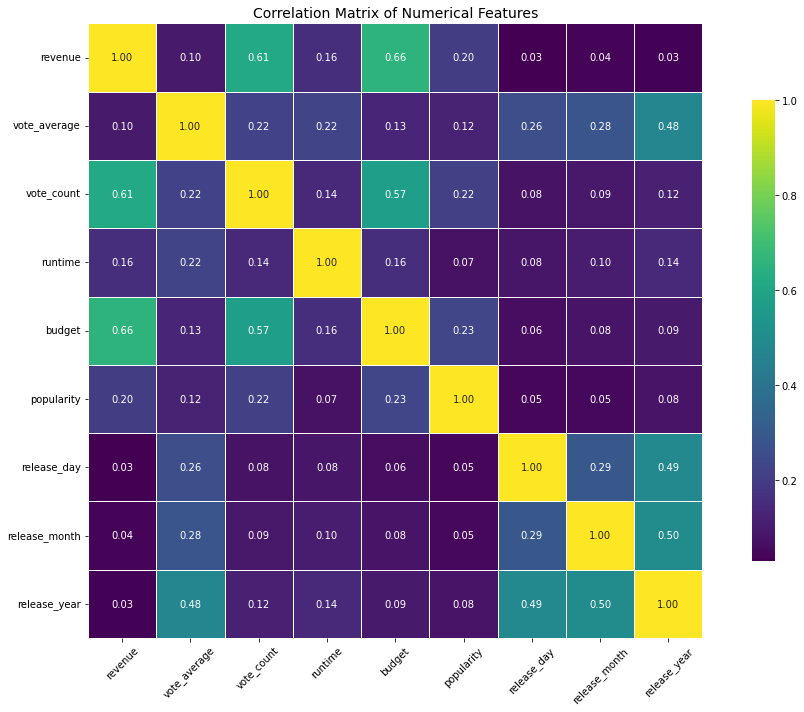

In [0]:
# Convert to Pandas
df_corr = train_df.select(numerical_features_target).toPandas()

# Plot correlation matrix using a pretty palette
plt.figure(figsize=(14, 10))
sns.heatmap(
    df_corr.corr(),
    annot=True,
    fmt=".2f",
    cmap="viridis",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 10} 
)
plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

No features highly correlate with each other (no correlation above 0.7). 

---
## Chi-Square Test (boolean features)
---
We are using chi-square on binary features - scaling is unnecessary. Thus, we will assemble separate vector from booleans and then perform the test.

In [0]:
# Discretize the revenue target into quantile buckets
discretizer = QuantileDiscretizer(numBuckets=4, inputCol="revenue", outputCol="revenue_bucket")
train_binned = discretizer.fit(train_df).transform(train_df)

# Use only boolean features 
input_features = boolean_features 

# Assemble into feature vector
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
assembled = assembler.transform(train_binned)

# Apply Chi-Square feature selection
selector = ChiSqSelector(numTopFeatures=10, featuresCol="features", labelCol="revenue_bucket", outputCol="selected_features")
selector_model = selector.fit(assembled)

# Get selected feature indices
selected_feature_indices = selector_model.selectedFeatures

# Print feature names
print("Top boolean features selected by Chi-Square test:")
for i in selected_feature_indices:
    print(f"- {input_features[i]}")

Top boolean features selected by Chi-Square test:
- adult
- en_bool
- tagline_bool
- released_bool
- genre_action
- genre_adventure
- genre_comedy
- genre_drama
- genre_thriller
- prodco_warner_bros_pictures


---
## Model-Based Importance for Decision Tree
---
Decision trees do not need scaled features, therefore we will assemble a new vector using all the features for this feature selection method. 

In [0]:
# Use full train_df with all features + target
all_features = train_df.drop("revenue").columns

# Assemble features
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
train_assembled = assembler.transform(train_df)

# Fit Decision Tree
tree = DecisionTreeRegressor(featuresCol="features", labelCol="revenue")
model = tree.fit(train_assembled)

# Get feature importances
importances = model.featureImportances.toArray()
feature_importance_list = list(zip(all_features, importances))

# Sort and print
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
print("Feature Importances (Descending):\n")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


Feature Importances (Descending):

budget: 0.5821
vote_count: 0.2264
runtime: 0.0491
release_month: 0.0488
release_year: 0.0383
popularity: 0.0227
genre_adventure: 0.0096
adult: 0.0076
keyword_sequel: 0.0042
country_china: 0.0039
released_bool: 0.0031
vote_average: 0.0024
genre_drama: 0.0020
release_day: 0.0000
en_bool: 0.0000
tagline_bool: 0.0000
genre_action: 0.0000
genre_comedy: 0.0000
genre_thriller: 0.0000
prodco_warner_bros_pictures: 0.0000
prodco_universal_pictures: 0.0000
prodco_paramount: 0.0000
country_united_states_of_america: 0.0000
country_united_kingdom: 0.0000
country_france: 0.0000
country_germany: 0.0000
keyword_duringcreditsstinger: 0.0000
keyword_based_on_novel_or_book: 0.0000


---
## Lasso Regression (L1 Regularization)
---
This feature selection method needs scaled features. Thus, we will use the vector assembled with scaled features.

In [0]:
# Define Lasso (L1) model
lr_l1 = LinearRegression(featuresCol="features", labelCol="revenue", elasticNetParam=1.0, regParam=0.3)
l1_model = lr_l1.fit(train_scaled)

# Get coefficients and feature names
coeffs = l1_model.coefficients.toArray()
# Get the input column names from the assembler you used
feature_names = assembler.getInputCols()

# Print results
for feature, coef in zip(feature_names, coeffs):
    if coef == 0.0:
        print(f"- {feature}: {coef:.4f} (excluded by L1 regularization)")
    else:
        direction = "positive" if coef > 0 else "negative"
        print(f"- {feature}: {coef:.4f} ({direction} relationship with revenue)")


- vote_average: -1394195.3562 (negative relationship with revenue)
- vote_count: 48318535.1233 (positive relationship with revenue)
- runtime: 6972013.9394 (positive relationship with revenue)
- adult: -294627.7598 (negative relationship with revenue)
- budget: 58367365.7113 (positive relationship with revenue)
- popularity: 2846509.9130 (positive relationship with revenue)
- release_day: 485873.9469 (positive relationship with revenue)
- release_month: -207353.2989 (negative relationship with revenue)
- release_year: -3947318.0791 (negative relationship with revenue)
- released_bool: -2538568.1540 (negative relationship with revenue)
- en_bool: 2387797.7081 (positive relationship with revenue)
- tagline_bool: -1100854.1528 (negative relationship with revenue)
- genre_action: -2967067.0109 (negative relationship with revenue)
- genre_adventure: 2938089.9911 (positive relationship with revenue)
- genre_comedy: 1574962.4560 (positive relationship with revenue)
- genre_drama: -1342000.741

---
## Define Final Features
---

In [0]:
dt_final_features = ['budget', 'vote_count', 'runtime', 'release_month', 'release_year',
                     'popularity', 'genre_adventure', 'adult', 'keyword_sequel', 'country_china',
                     'released_bool', 'vote_average', 'genre_drama']
dt_final_features_threshold = ['budget', 'vote_count', 'runtime', 'release_month', 'release_year', 'popularity']

In [0]:
# Assemble vector for decision trees based models (all deemed important columns)
assembler_dt = VectorAssembler(inputCols=dt_final_features, outputCol="features")
train_dt = assembler_dt.transform(train_df)
test_dt  = assembler_dt.transform(test_df)

# Assemble vector for decision trees based models (with threshold set to 0.01)
assembler_dt = VectorAssembler(inputCols=dt_final_features_threshold, outputCol="features")
train_dtt = assembler_dt.transform(train_df)
test_dtt  = assembler_dt.transform(test_df)

---
## Train and evaluate models
---
We'll train and compare:

1. Linear Regression

2. Decision Tree Regressor

3. Random Forest Regressor

4. Gradient Boosted Tree Regressor

5. Generalized Linear Model

In [0]:
results = []

---
## Linear Regression
---

In [0]:
# Train Linear Regression on pre-scaled features
lr = LinearRegression(featuresCol="features", labelCol="revenue")
lr_model = lr.fit(train_scaled)

# Predict and evaluate on test set
lr_predictions = lr_model.transform(test_scaled)

# Evaluate
lr_rmse = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse").evaluate(lr_predictions)
lr_r2   = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(lr_predictions)

results.append(("Linear Regression", lr_rmse, lr_r2))

---
## Decision Tree Regressor
---

In [0]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol="revenue")
dt_model = dt.fit(train_dt)

dt_predictions = dt_model.transform(test_dt)

dt_rmse = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse").evaluate(dt_predictions)
dt_r2   = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(dt_predictions)

results.append(("Decision Tree Regressor", dt_rmse, dt_r2))


In [0]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol="revenue")
dt_model = dt.fit(train_dtt)

dt_predictions = dt_model.transform(test_dtt)

dt_rmse = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse").evaluate(dt_predictions)
dt_r2   = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(dt_predictions)

results.append(("Decision Tree Regressor (using features above threshold)", dt_rmse, dt_r2))

---
## Random Forest Regressor
---

In [0]:
rf = RandomForestRegressor(featuresCol="features", labelCol="revenue", numTrees=100, maxDepth=10)
rf_model = rf.fit(train_dt)

rf_predictions = rf_model.transform(test_dt)

rf_rmse = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse").evaluate(rf_predictions)
rf_r2   = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(rf_predictions)

results.append(("Random Forest Regressor", rf_rmse, rf_r2))

In [0]:
rf = RandomForestRegressor(featuresCol="features", labelCol="revenue", numTrees=100, maxDepth=10)
rf_model = rf.fit(train_dtt)

rf_predictions = rf_model.transform(test_dtt)

rf_rmse = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse").evaluate(rf_predictions)
rf_r2   = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(rf_predictions)

results.append(("Random Forest Regressor (using features above threshold)", rf_rmse, rf_r2))

---
## Gradient Boosted Tree Regressor
---

In [0]:
gbt = GBTRegressor(featuresCol="features", labelCol="revenue", maxIter=50, maxDepth=5)
gbt_model = gbt.fit(train_dt)

gbt_predictions = gbt_model.transform(test_dt)

gbt_rmse = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse").evaluate(gbt_predictions)
gbt_r2   = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(gbt_predictions)

results.append(("Gradient Boosted Trees", gbt_rmse, gbt_r2))

---
## Generalized Linear Model
---
Supports skewed data

In [0]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define and fit the GLR model
glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="revenue",
    family="tweedie",     # tweedie distribution is more robust to skewed data
    link="log"       
)

glr_model = glr.fit(train_scaled)

# Predict on test data
glr_predictions = glr_model.transform(test_scaled)

# Evaluate performance
evaluator = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse")
glr_rmse = evaluator.evaluate(glr_predictions)
glr_r2   = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(glr_predictions)

# Save results
results.append(("Generalized Linear Model (Gaussian)", glr_rmse, glr_r2))

---
## Results
---
We will print the results of all the models tested. We will select the one with the lowest RMSE and highest r^2 and hypertune its parameters.

In [0]:
print("Model Evaluation Results:")
for model_name, rmse, r2 in results:
    print(f"{model_name}:\n  RMSE = {rmse:.2f}\n  R² = {r2:.4f}\n")

Model Evaluation Results:
Linear Regression:
  RMSE = 88065580.76
  R² = 0.6172

Decision Tree Regressor:
  RMSE = 93301589.70
  R² = 0.5704

Decision Tree Regressor (using features above threshold):
  RMSE = 92767701.69
  R² = 0.5753

Random Forest Regressor:
  RMSE = 84337467.71
  R² = 0.6490

Random Forest Regressor (using features above threshold):
  RMSE = 89577807.65
  R² = 0.6040

Gradient Boosted Trees:
  RMSE = 87420789.67
  R² = 0.6228

Generalized Linear Model (Gaussian):
  RMSE = 88065580.76
  R² = 0.6172



---
## Hyper-parameter tuning for the best performing model (Random Forest Regressor)
---
We define a small parameter grid and hypertune three parameters:
1. Number of trees

2. Max depth of a tree

3. Max number of Bins to split continuous features

In [0]:
# Define parameter grid
param_grid = {
    "numTrees": [50, 100],
    "maxDepth": [5, 10, 15],
    "maxBins": [32, 64]
}

# Evaluator
evaluator = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse")

# Track results
rf_results = []

# Manual grid search
for num_trees in param_grid["numTrees"]:
    for max_depth in param_grid["maxDepth"]:
        for max_bins in param_grid["maxBins"]:
            # Define model with current params
            rf = RandomForestRegressor(
                featuresCol="features",
                labelCol="revenue",
                numTrees=num_trees,
                maxDepth=max_depth,
                maxBins=max_bins,
                seed=42
            )
            # Train
            model = rf.fit(train_dt)
            # Predict
            preds = model.transform(test_dt)
            # Evaluate
            rmse = evaluator.evaluate(preds)
            r2 = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2").evaluate(preds)

            rf_results.append(((num_trees, max_depth, max_bins), rmse, r2))

            print(f"numTrees={num_trees}, maxDepth={max_depth}, maxBins={max_bins} → RMSE={rmse:.2f}, R²={r2:.4f}")


numTrees=50, maxDepth=5, maxBins=32 → RMSE=88790089.60, R²=0.6109
numTrees=50, maxDepth=5, maxBins=64 → RMSE=85417527.91, R²=0.6399
numTrees=50, maxDepth=10, maxBins=32 → RMSE=84624803.57, R²=0.6466
numTrees=50, maxDepth=10, maxBins=64 → RMSE=80561788.48, R²=0.6797
numTrees=50, maxDepth=15, maxBins=32 → RMSE=84803151.62, R²=0.6451
numTrees=50, maxDepth=15, maxBins=64 → RMSE=80974354.75, R²=0.6764
numTrees=100, maxDepth=5, maxBins=32 → RMSE=88494789.68, R²=0.6135
numTrees=100, maxDepth=5, maxBins=64 → RMSE=85876583.39, R²=0.6360
numTrees=100, maxDepth=10, maxBins=32 → RMSE=83287069.77, R²=0.6576
numTrees=100, maxDepth=10, maxBins=64 → RMSE=81504474.90, R²=0.6721
numTrees=100, maxDepth=15, maxBins=32 → RMSE=83693183.31, R²=0.6543


In [0]:
# Sort by RMSE (lower is better)
best_config = sorted(rf_results, key=lambda x: x[1])[0]

print("\nBest Random Forest Configuration:")
print(f"numTrees={best_config[0][0]}, maxDepth={best_config[0][1]}, maxBins={best_config[0][2]}")
print(f"RMSE: {best_config[1]:.2f}, R²: {best_config[2]:.4f}")

Turns out the best parameter combination is numTrees=50, maxDepth=10, maxBins=64 with the following results achieved on the test set: RMSE=80561788.48, R²=0.6797